# Homework 6: Deep Q-Networks

In this assignment you will implement deep q-learning and test this algorithm on the Frozen-lake environment. 

In [1]:
import os
import numpy as np
import numpy.random as npr
import random
import matplotlib.pyplot as plt
import copy
from collections import defaultdict, namedtuple
from itertools import count
from more_itertools import windowed
from tqdm import tqdm

import tensorflow as tf
import tensorflow.contrib.slim as slim

from gym.envs.toy_text.frozen_lake import FrozenLakeEnv

plt.style.use('ggplot')

# Remove this if you want to use a GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ''

### $\epsilon$-Greedy Decay

In [2]:
class LinearSchedule(object):                                                                                                                                                                                                                                           
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):                                                                                                                                                                                                     
        '''
        Linear interpolation between initial_p and final_p over                                                                                                                                                                                                      
        schedule_timesteps. After this many timesteps pass final_p is                                                                                                                                                                                                   
        returned.                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                        
        Args:                                                                                                                                                                                                                                                    
            - schedule_timesteps: Number of timesteps for which to linearly anneal initial_p to final_p                                                                                                                                                                                                                                                  
            - initial_p: initial output value                                                                                                                                                                                                                                        
            -final_p: final output value                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                       
        self.schedule_timesteps = schedule_timesteps                                                                                                                                                                                                                    
        self.final_p = final_p                                                                                                                                                                                                                                          
        self.initial_p = initial_p                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                         
    def value(self, t):                                                                                                                                                                                                                                                 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)                                                                                                                                                                                                         
        return self.initial_p + fraction * (self.final_p - self.initial_p) 

### Replay Buffer

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, size):
        '''
        Replay buffer used to store transition experiences. Experiences will be removed in a 
        FIFO manner after reaching maximum buffer size.
        
        Args:
            - size: Maximum size of the buffer.
        '''
        self.size = size
        self.memory = list()
        self.idx = 0
        
    def add(self, *args):
        if len(self.memory) < self.size:
            self.memory.append(None)
        self.memory[self.idx] = Transition(*args)
        self.idx = (self.idx + 1) % self.size
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### Exercise 1 (\# Points):

Implement the necessary Tensorflow operations for a Deep Q-Network. This should include the following:
1. Any number of fully connected layers which take the state as input and outputs the q-values for each possible action. You should only need a few small fully conected layers as the environments are relatively simple.
2. A prediction operation which returns the index of the best action.
3. Operations to compute the loss.
4. A optimizer to minimize the loss, i.e. SGD, RMSProp, Adam. 

In [4]:
class DQN(object):
    def __init__(self, state_shape, action_shape, lr=0.001):
        '''
        Deep Q-Network Tensorflow model.
        
        Args:
            - state_shape: Input state shape 
            - action_shape: Output action shape
        '''
        self.input = tf.placeholder(shape=[None, state_shape], dtype=tf.float32)
        self.fc1 = slim.fully_connected(self.input, 32)
        self.fc2 = slim.fully_connected(self.fc1, 64)
        self.q_head = slim.fully_connected(self.fc2, action_shape, activation_fn=None)
        self.predict = tf.argmax(self.q_head, 1)
        
        self.target_Q = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, action_shape, dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.q_head, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.target_Q - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=lr)
        self.updateModel = self.trainer.minimize(self.loss)

### Exercise 2 (\# Points):

Implement the following method which will be used when optimizing the model. The optimize_model method should compute the target Q-values from the batch and use the optimizer op created in the previous exercise. **Note:** We are using a target network to compute the target q-values in order to stabalize training.

In [5]:
def optimize_model(session, policy_net, target_net, batch, gamma):
    '''
    Calculates the target Q-values for the given batch and uses them to update the model.
    
    Args:
        - session: Tensorflow session
        - policy_net: Policy DQN model
        - target_net: DQN model used to generate target Q-values
        - batch: Batch of experiences uesd to optimize model
        - gamma: Discount factor
    '''
    batch_size = len(batch[0])
    not_done_masks = np.logical_not(batch.done)
    not_done_next_states = np.expand_dims(batch.next_state, axis=1)[not_done_masks]
    
    next_state_q = np.zeros(batch_size)
    next_state_q[not_done_masks] = session.run(target_net.q_head, 
                                               feed_dict={target_net.input:not_done_next_states}).max(axis=1)
    expected_q = batch.reward + (gamma * next_state_q)
    
    session.run(policy_net.updateModel, feed_dict={policy_net.input:np.vstack(batch.state),
                                                   policy_net.target_Q:expected_q, 
                                                   policy_net.actions:batch.action})

def update_target_graph_op(tf_vars, tau):
    '''
    Creates a Tensorflow op which updates the target model towards the policy model by a small amount.
    
    Args:
        - tf_vars: All trainable variables in the Tensorflow graph
        - tau: Amount to update the target model
    '''
    total_vars = len(tf_vars)
    update_ops = list()
    for idx,var in enumerate(tf_vars[0:total_vars//2]):
        op = tf_vars[idx + total_vars//2].assign((var.value()*tau) + \
                                                 ((1-tau)*tf_vars[idx+total_vars//2].value()))
        update_ops.append(op)
    return update_ops

def update_target(session, update_ops):
    '''
    Calls each update op to update the target model.
    
    Args:
        - session: Tensorflow session
        - update_ops: The update ops which moves the target model towards the policy model
    '''
    for op in update_ops:
        session.run(op)

### Exercise 3 (\# Points):

Implement the below method to train the model in the given environment. You should choose actions in a $\epsilon$-greedy fashion while annealing $\epsilon$ over time as we did in the previous assignment.

In [6]:
def train(env, num_episodes=500, gamma=0.99, batch_size=64,
          annealing_steps=1000, s_epsilon=1.0, f_epsilon=0.1):
    '''
    DQN algorithm
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - batch_size: Number of experiences in a batch
        - annealing_steps: The number of steps to anneal epsilon over
        - s_epsilon: The initial epsilon value for e-greedy action selection
        - f_epsilon: The final epsilon value for the e-greedy action selection
        
    Returns: (policy_net, episode_rewards)
        - policy_net: Trained DQN model
        - episode_rewards: Numpy array containing the reward of each episode during training
    '''
    policy_net = DQN(1, env.action_space.n)
    target_net = DQN(1, env.action_space.n)
    target_ops = update_target_graph_op(tf.trainable_variables(), 0.1)
    
    memory = ReplayMemory(20000)
    epsilon = LinearSchedule(annealing_steps, f_epsilon, s_epsilon)

    pbar = tqdm(range(num_episodes))
    pbar.set_description('Steps: 0 | Reward: 0.0 | Epsilon: {}'.format(s_epsilon))
    
    steps_done = 0
    episode_rewards = list()
    
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    for i_episode in pbar:
        # Initialize the environment and state
        state = env.reset()
        total_reward = 0
        for t in count():
            # Select and perform an action
            if npr.rand() > epsilon.value(i_episode):
                action = session.run(policy_net.predict, feed_dict={policy_net.input:[[state]]})[0]
            else:
                action = npr.choice(env.action_space.n)
                
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store the transition in memory
            memory.add(state, action, next_state, reward, int(done))

            # Move to the next state
            state = copy.copy(next_state)
            steps_done += 1

            # Perform one step of the optimization
            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))
                optimize_model(session, policy_net, target_net, batch, gamma)
    
                # Update the target network
                update_target(session, target_ops)
        
            # Check if the episode is over and break if it is
            if done:
                episode_rewards.append(total_reward)
                break
    
        # Update progress bar
        pbar.set_description('Steps: {} | Reward: {} | Epsilon: {:.2f}' \
                             .format(t, episode_rewards[-1], epsilon.value(i_episode)))
    return policy_net, episode_rewards

#### Test your implentation on the Frozen-lake (both slippery and not slippery) environment. You should plot the episode rewards over time. It might be helpful to smooth this curve over a time window of 100 episodes in order to get  a more clear picture of the learning process.

Steps: 5 | Reward: 1.0 | Epsilon: 0.00: 100%|██████████| 2000/2000 [01:13<00:00, 27.23it/s] 


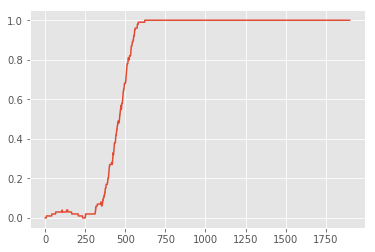

In [7]:
frozen_lake_env = FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=False)

policy_net, rewards = train(frozen_lake_env, batch_size=64, num_episodes=2000, annealing_steps=100, f_epsilon=0.0, gamma=0.9)
avg_reward = np.mean(list(windowed(rewards, 100)), axis=1)
plt.plot(avg_reward)
plt.show()